In [1]:
import sys, os, math, glob, time, random
import _pickle as cPickle
import numpy as np

## Audio
import librosa, librosa.display
import IPython.display as ipd

## Deep learning
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import * # ELU
from keras.layers.merge import *
from keras.losses import *
from keras.metrics import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications import *
from keras.regularizers import *

Using TensorFlow backend.


In [12]:
%load_ext autoreload
%autoreload 2

print('keras',      keras.__version__)
print('tensorflow', tf.__version__)

keras 2.0.8
tensorflow 1.3.0


# Data

In [2]:
pwd = os.getcwd()
data_dir = os.path.join(pwd, '..','..','..','Speech Audio Text','3) Dataset','Reverb_2')

noisy_dir = os.path.join(data_dir, 'noisy_trainset_28spk_wav')
clean_dir = os.path.join(data_dir, 'clean_trainset_28spk_wav')

noise_files_list = []
for noise_wav in glob.glob( os.path.join(noisy_dir, '*.wav') ):
    noise_wav_term = noise_wav[len(noisy_dir)+1:len(noise_wav)-4]
    noise_files_list.append(noise_wav_term)
len(noise_files_list)

E:/Leonard HDD/Dropbox/Speech Audio Text/3) Dataset/Reverb_2\noisy_trainset_28spk_wav
E:/Leonard HDD/Dropbox/Speech Audio Text/3) Dataset/Reverb_2\clean_trainset_28spk_wav


11572

## v6_10
Compare loss of Enhanced_Spect_feat with GroundTruth_Spect_feat

In [18]:
Archi_dir = "v6_10/"
Weights_path = Archi_dir+"Logs/"
Ckpt_Mod_Weights_fold = Archi_dir+"Checkpoint_Model_Weights/"
plot_path_dir = Archi_dir+'Plots/'
model_path = Weights_path+Archi_dir[:-1]+"_model_v6_10.json"
weights_path = Weights_path+Archi_dir[:-1]+"_weights_v6_10.h5"

## Load Model & Weights
model_cropped_v6 = load_model(model_path, 'path', weights_path)
print('\n######################## Summary of Overall Architecture ########################')
model_cropped_v6.summary()
print('\n######################## Summary of Conv_SubNet ########################')
model_cropped_v6.get_layer('Conv_SubNet').summary()
print('\n######################## Summary of Bi_RNN_SubNet ########################')
model_cropped_v6.get_layer('Bi_RNN_SubNet').summary()

Loaded model from path : v6_10/Logs/v6_10_model_v6_10.json
Loaded weights         : v6_10/Logs/v6_10_weights_v6_10.h5

######################## Summary of Overall Architecture ########################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 129, 100, 1)       0         
_________________________________________________________________
Conv_SubNet (Model)          (None, 129, 100, 1)       14889     
_________________________________________________________________
reshape_11 (Reshape)         (None, 129, 100)          0         
_________________________________________________________________
permute_11 (Permute)         (None, 100, 129)          0         
_________________________________________________________________
Bi_RNN_SubNet (Model)        (None, 100, 129)          350622    
_________________________________________________________________
permute

In [5]:
## Data details
nfft = 256;					print('\nnfft',nfft)
win_length = nfft;			print('win_length',win_length)
hop_length = win_length//4;	print('hop_length',hop_length)
num_freq = nfft//2 +1;	print('\nnum_freq',num_freq)
num_time = 100;			print('num_time',num_time)
num_channel = 1;		print('num_channel',num_channel)

## Path
trainset_dir = os.path.join(pwd,'..','..','..','Speech Audio Text','3) Dataset','Reverb_1','trainset')
print(get_immediate_subdirectories(trainset_dir))
Anec_dir = os.path.join(trainset_dir,'AnechoicSpeech','wav')
print(get_immediate_subdirectories(Anec_dir))
Rev_dir = os.path.join(trainset_dir,'RevSpeech','wav')
print(get_immediate_subdirectories(Rev_dir))
RT_list = get_immediate_subdirectories(Rev_dir)
noise_2 = os.path.join(pwd,'noise','comb_noise_2.wav')


nfft 256
win_length 256
hop_length 64

num_freq 129
num_time 100
num_channel 1
['AnechoicSpeech', 'CleanSpeech', 'RevSpeech']
['RT60=0.1_version1', 'RT60=0.2_version1', 'RT60=0.3_version1', 'RT60=0.4_version1', 'RT60=0.5_version1', 'RT60=0.6_version1', 'RT60=0.7_version1', 'RT60=0.8_version1', 'RT60=0.9_version1', 'RT60=1_version1']
['RT60=0.1_version1', 'RT60=0.2_version1', 'RT60=0.3_version1', 'RT60=0.4_version1', 'RT60=0.5_version1', 'RT60=0.6_version1', 'RT60=0.7_version1', 'RT60=0.8_version1', 'RT60=0.9_version1', 'RT60=1_version1']


## Data Visualisation

rt RT60=0.1_version1
snr_scale 0.5
y


x_rev


x_noisy


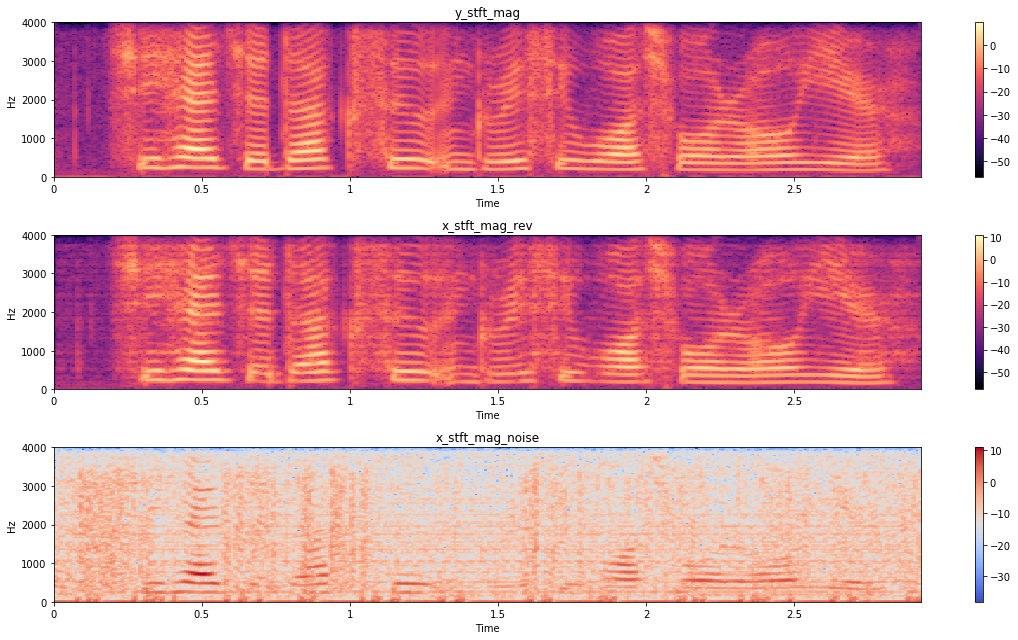

In [34]:
## load full
rt = RT_list[0]; print('rt', rt)
wav_file = 'TRAIN_DR1_FCJF0_SA1.wav'
snr_scale = .5; print('snr_scale', snr_scale)

n_2,sr = librosa.load( noise_2, sr=8000)

y,  sr = librosa.load( os.path.join(Anec_dir,rt,wav_file), sr=8000)
y_stft = librosa.stft(y, n_fft=nfft, hop_length=hop_length, win_length=win_length)
y_stft_mag = np.abs(y_stft)
y_stft_pha = np.angle(y_stft)

x_rev,  sr = librosa.load( os.path.join(Rev_dir,rt,wav_file), sr=8000)
x_stft = librosa.stft(x_rev, n_fft=nfft, hop_length=hop_length, win_length=win_length)
x_stft_mag_rev = np.abs(x_stft)

idx = np.random.randint(0, len(n_2)-len(x_rev))
x_noisy = x_rev + snr_scale*n_2[idx:idx+len(x_rev)]
x_stft_n = librosa.stft(x_noisy, n_fft=nfft, hop_length=hop_length, win_length=win_length)
x_stft_mag_noise = np.abs(x_stft_n)
x_stft_pha_n = np.angle(x_stft_n)

print('y'); display_audio(y, None, sr, 'audio', hop_length=None)
print('x_rev'); display_audio(x_rev, None, sr, 'audio', hop_length=None)
print('x_noisy'); display_audio(x_noisy, None, sr, 'audio', hop_length=None)

k=3;col=1;l=1; plt.figure(figsize=(16,k*k));
plt.subplot(k,col,l); display_audio(librosa.power_to_db(y_stft_mag), 'y_stft_mag', sr, 'spec', hop_length=hop_length, colorbar=1); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(x_stft_mag_rev), 'x_stft_mag_rev', sr, 'spec', hop_length=hop_length, colorbar=1); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(x_stft_mag_noise), 'x_stft_mag_noise', sr, 'spec', hop_length=hop_length, colorbar=1); l+=1
plt.tight_layout()

## Enhancement on a crop that is fit to the training dimension

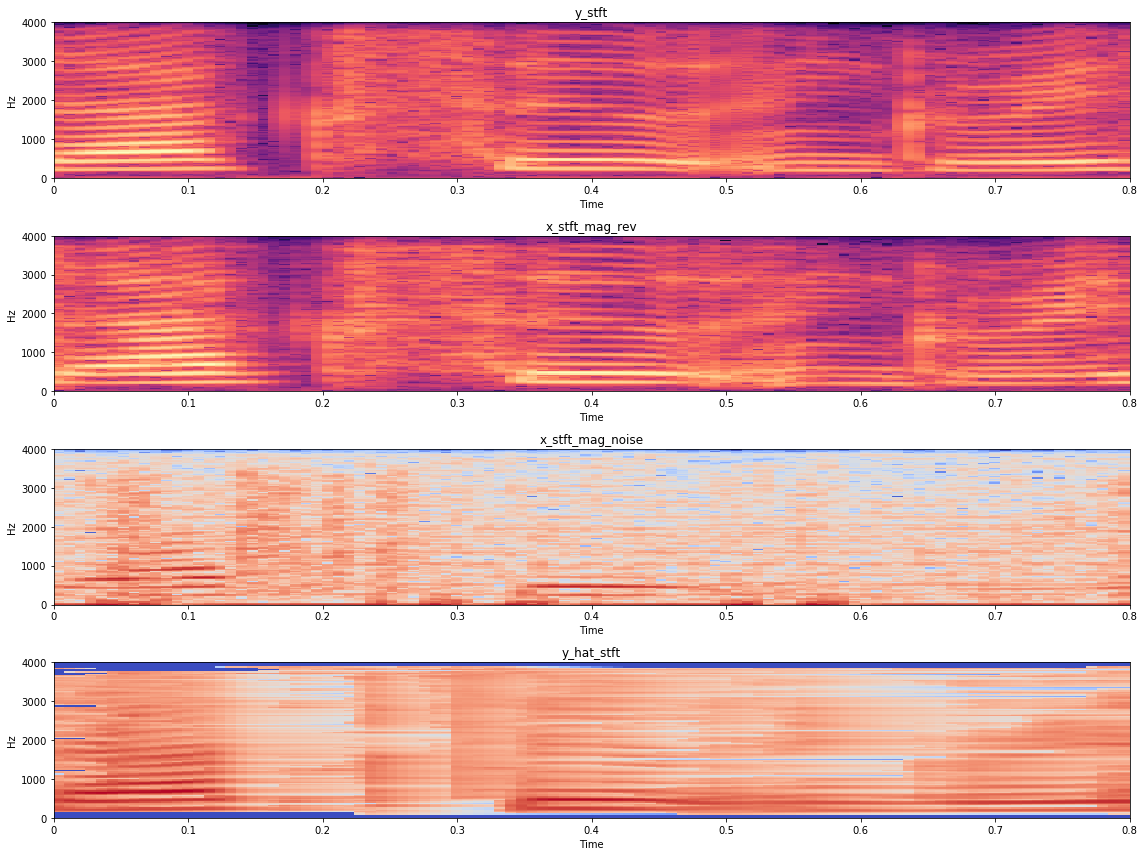

In [35]:
####################################### Enhance Cropped #####################################
y_hat_stft = model_cropped_v6.predict(x_stft_mag_noise[:,100:100+num_time].reshape(1,num_freq,num_time,num_channel))[0,:,:,0]
k=4;col=1;l=1; plt.figure(figsize=(16,3*k));
plt.subplot(k,col,l); display_audio(librosa.power_to_db(y_stft[:,100:100+num_time]), 'y_stft', sr, 'spec', hop_length=hop_length); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(x_stft_mag_rev[:,100:100+num_time]), 'x_stft_mag_rev', sr, 'spec', hop_length=hop_length); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(x_stft_mag_noise[:,100:100+num_time]), 'x_stft_mag_noise', sr, 'spec', hop_length=hop_length); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(y_hat_stft), 'y_hat_stft', sr, 'spec', hop_length=hop_length); l+=1
plt.tight_layout()

####################################### Construct longer model #####################################
time_step_longer = x_stft_mag_noise.shape[1]
Inp1 = Input(shape=(num_freq,time_step_longer,num_channel), name="Input")
conv_subnet = model_cropped_v6.get_layer('Conv_SubNet')
model_long_1 = Model(Inp1,conv_subnet(Inp1))
Inp2 = Input(shape=(time_step_longer,num_freq), name="Input")
rnn_subnet = model_cropped_v6.get_layer('Bi_RNN_SubNet')
model_long_2 = Model(Inp2,rnn_subnet(Inp2))
########################### Architecture (Long) ########################
Inp = Input(shape=(num_freq, time_step_longer, 1), name="Input")
conv_sub = model_long_1(Inp)
x_lay = Reshape((num_freq,time_step_longer))(conv_sub)
x_lay = Permute((2,1))(x_lay)
rnn_sub = model_long_2(x_lay)
x_lay = Permute((2,1))(rnn_sub)
x_lay = Reshape((num_freq,time_step_longer,1))(x_lay)
########################### Printing information ########################
model_full_v6 = Model(Inp,x_lay)

## Enhancement on a variable length audio

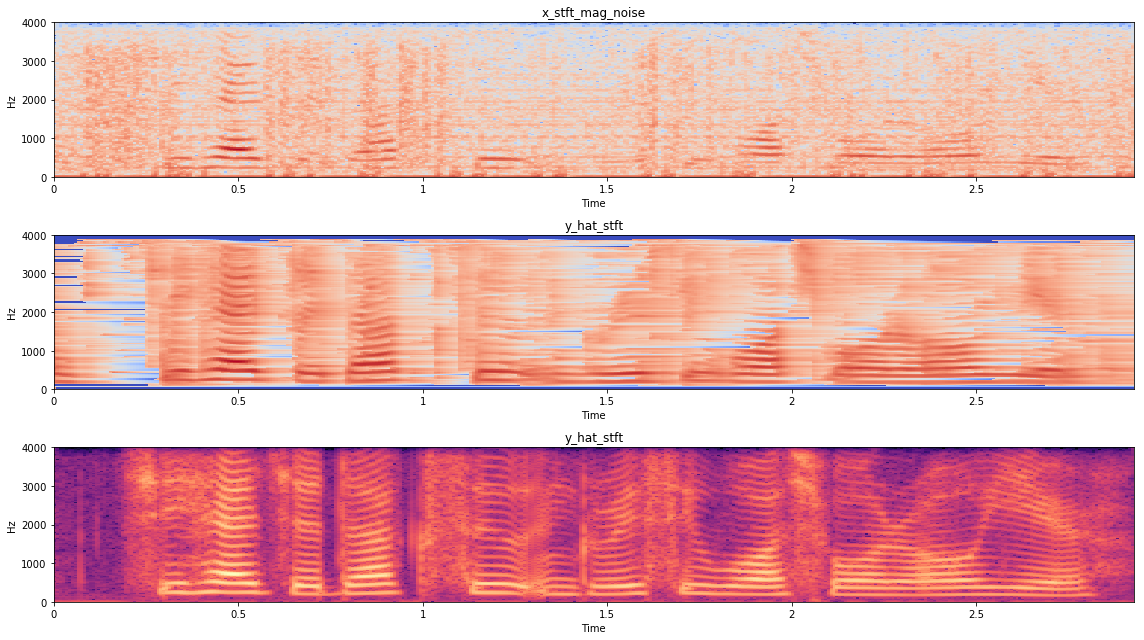

In [36]:
## Enhance Full
y_hat_stft_full = model_full_v6.predict(x_stft_mag_noise.reshape(1,num_freq,time_step_longer,num_channel))[0,:,:,0]
k=3;col=1;l=1; plt.figure(figsize=(16,3*k)); 
plt.subplot(k,col,l); display_audio(librosa.power_to_db(x_stft_mag_noise), 'x_stft_mag_noise', sr, 'spec', hop_length=hop_length); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(y_hat_stft_full), 'y_hat_stft', sr, 'spec', hop_length=hop_length); l+=1
plt.subplot(k,col,l); display_audio(librosa.power_to_db(y_stft), 'y_hat_stft', sr, 'spec', hop_length=hop_length); l+=1
plt.tight_layout()

## Convert to audio form

y


x_rev


x_noisy


y_hat_istft_full


y_hat_istft_true_pha


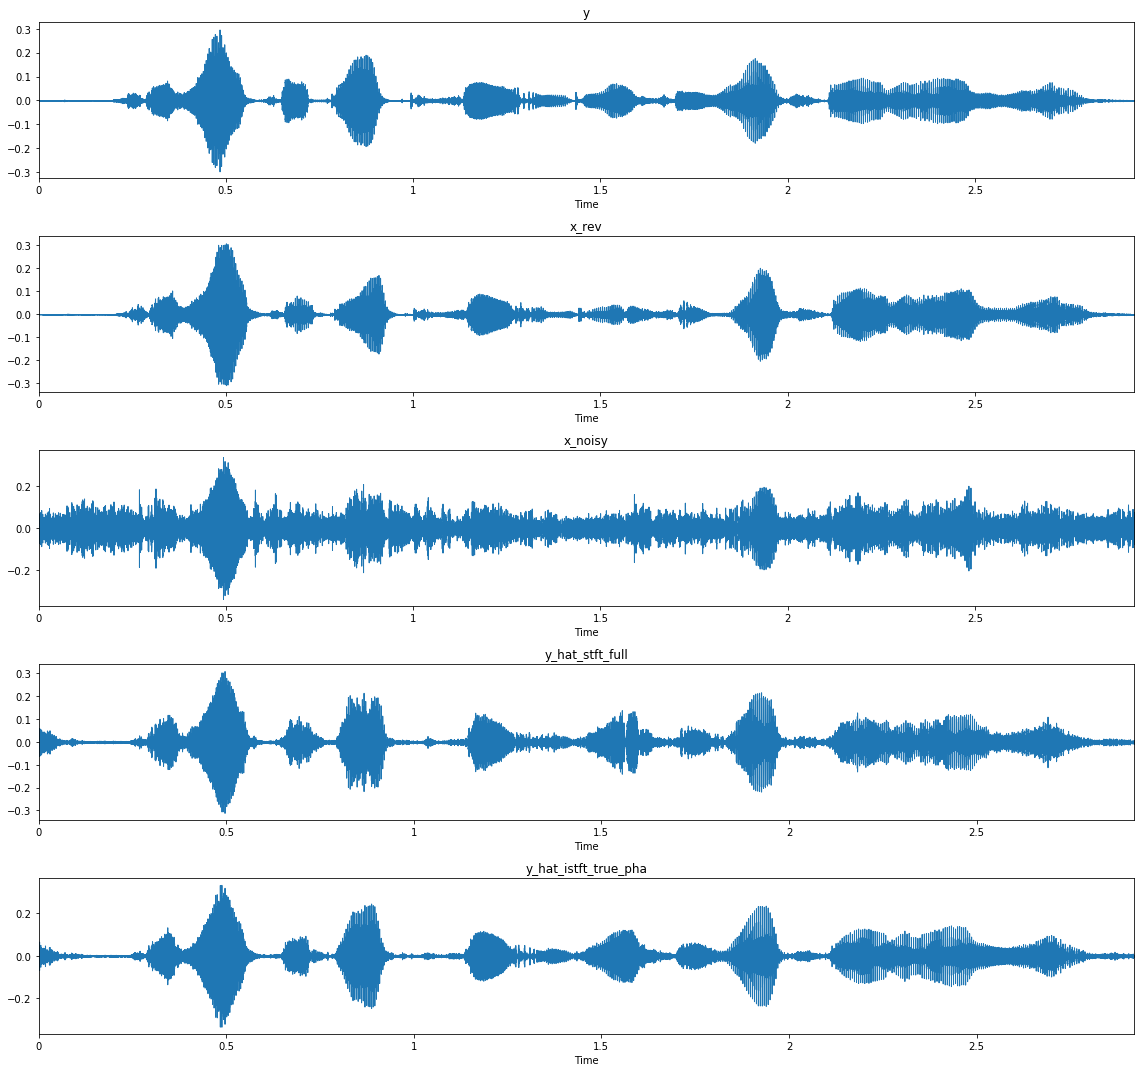

In [37]:
## ISTFT
y_hat_istft_full = spect2wav(None, y_hat_stft_full, x_stft_pha_n, [hop_length, win_length]) 
y_hat_istft_true_pha = spect2wav(None, y_hat_stft_full, y_stft_pha, [hop_length, win_length]) 

print('y'); display_audio(y, None, sr, 'audio')
print('x_rev'); display_audio(x_rev, None, sr, 'audio')
print('x_noisy'); display_audio(x_noisy, None, sr, 'audio');
print('y_hat_istft_full'); display_audio(y_hat_istft_full, None, sr, 'audio');
print('y_hat_istft_true_pha'); display_audio(y_hat_istft_true_pha, None, sr, 'audio');

k=5;col=1;l=1; plt.figure(figsize=(16,3*k)); 
plt.subplot(k,col,l); display_audio(y, 'y', sr, 'wave'); l+=1
plt.subplot(k,col,l); display_audio(x_rev, 'x_rev', sr, 'wave'); l+=1
plt.subplot(k,col,l); display_audio(x_noisy, 'x_noisy', sr, 'wave'); l+=1
plt.subplot(k,col,l); display_audio(y_hat_istft_full, 'y_hat_stft_full', sr, 'wave'); l+=1
plt.subplot(k,col,l); display_audio(y_hat_istft_true_pha, 'y_hat_istft_true_pha', sr, 'wave'); l+=1
plt.tight_layout()